# Projet Python 2025

# Etape 5 : Interprétation et visualisation

## Aperçu du DataFrame

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("alertes_enrichies.csv")
df.head()


,Titre Alerte,Type,Description,Lien,Date,CVE ID,Description CVE,CWE,Nature de la faille,Score CVSS,Gravité CVSS,Score EPSS,Gravité EPSS,Éditeur,Produit,Versions Affectées
0,Multiples vulnérabilités dans Trend Micro Apex...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Thu, 08 Jan 2026 00:00:00 +0000",CVE-2025-69259,A message unchecked NULL return value vulnerab...,CWE-346,CWE-346: Origin Validation Error,7.5,Élevée,0.00104,Faible,"Trend Micro, Inc.",Trend Micro Apex Central,2019 (14.0)
1,Vulnérabilité dans Tenable Nessus Agent (08 ja...,Avis,Une vulnérabilité a été découverte dans Tenabl...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Thu, 08 Jan 2026 00:00:00 +0000",CVE-2025-36640,A vulnerability has been identified in the ins...,CWE-269,CWE-269 Improper Privilege Management,NaN,Non disponible,0.00012,Faible,Tenable,Nessus Agent,"0, 11.0.0"
2,Multiples vulnérabilités dans GitLab (08 janvi...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Thu, 08 Jan 2026 00:00:00 +0000",CVE-2025-64720,LIBPNG is a reference library for use in appli...,CWE-125,CWE-125: Out-of-bounds Read,7.1,Élevée,0.00074,Faible,pnggroup,libpng,">= 1.6.0, < 1.6.51"
3,Multiples vulnérabilités dans les produits Cen...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Thu, 08 Jan 2026 00:00:00 +0000",CVE-2025-13056,Improper Neutralization of Input During Web Pa...,CWE-79,CWE-79 Improper Neutralization of Input During...,6.8,Moyenne,0.00020,Faible,Centreon,Infra Monitoring,"25.10.0, 24.10.0, 24.04.0"
4,Vulnérabilité dans les produits Moxa (09 janvi...,Avis,Une vulnérabilité a été découverte dans les pr...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2023-38408,The PKCS#11 feature in ssh-agent in OpenSSH be...,Non disponible,NaN,NaN,Non disponible,0.68749,Élevée,NaN,NaN,NaN


## Lien entre score CVSS et score EPSS

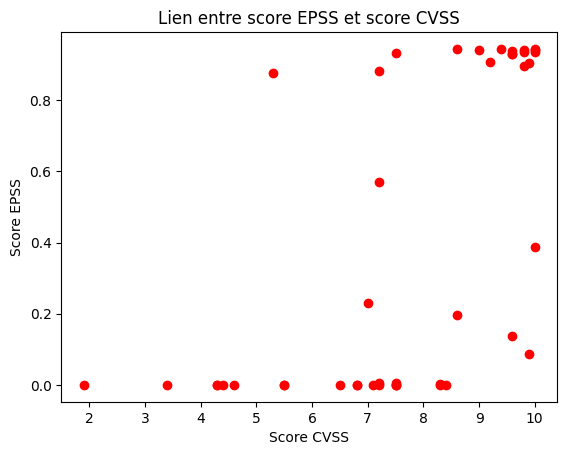

In [7]:
plt.plot(df.get("Score CVSS"), df.get("Score EPSS"), "ro")
plt.title("Lien entre score EPSS et score CVSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.show()

Ce graphique en nuage de points montre la corrélation entre les deux scores de sévérité.

CVSS = potentiel technique d'exploitabilité
EPSS = probabilité réelle d'exploitation
Les points sont dispersés, cela signifie que certaines vulnérabilités techniquement graves ne sont pas forcément exploitées en pratique (bon signe de sécurité).
Mais on remarque quand même en général que lorsqu'un EPSS est élevé, le score CVSS est de même.

## Nombre d'alertes par produit

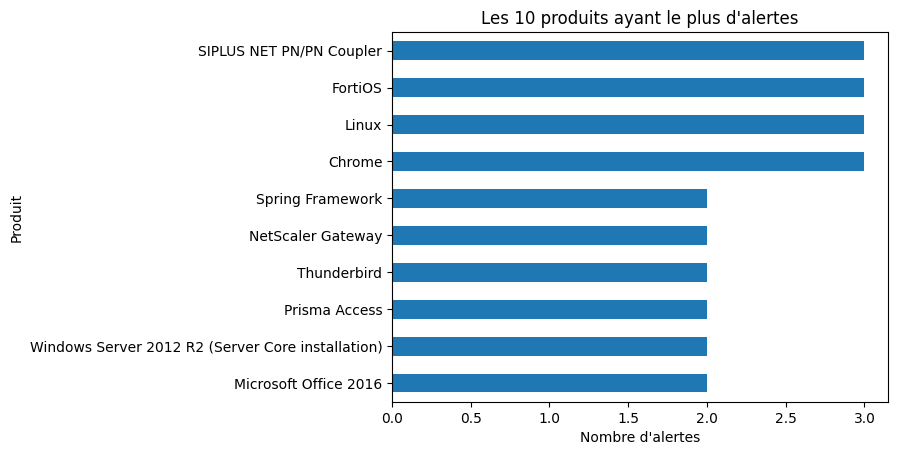

In [8]:
alertes_produit = df["Produit"].value_counts().nlargest(10)
alertes_produit.plot(kind="barh")
plt.title("Les 10 produits ayant le plus d'alertes")
plt.xlabel("Nombre d'alertes")
plt.gca().invert_yaxis()
plt.show()

Ce diagramme en barres horizontales classe les produits les plus affectés par les vulnérabilités. Les produits en haut ont le plus d'alertes de sécurité, ce qui devrait être votre priorité pour les correctifs.

## Diagramme circulaire des 10 types de vulnérabilités les plus présents + détails dans un tableau

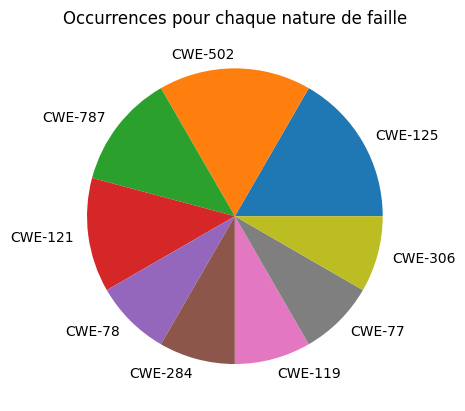

,count
Nature de la faille,
Execute unauthorized code or commands,6
CWE-125: Out-of-bounds Read,3
CWE-400: Uncontrolled Resource Consumption,2
CWE-119 Improper Restriction of Operations within the Bounds of a Memory Buffer,2
CWE-502: Deserialization of Untrusted Data,2
CWE-77 Improper Neutralization of Special Elements used in a Command ('Command Injection'),2
CWE-121: Stack-based Buffer Overflow,2
CWE-284 Improper Access Control,2
CWE-79 Improper Neutralization of Input During Web Page Generation (XSS or 'Cross-site Scripting'),2


In [9]:

nb_cwe = df["CWE"].value_counts().nlargest(10)
nb_cwe = nb_cwe.drop(labels=["Non disponible"])
nb_cwe.plot(kind="pie")
plt.xlabel("")
plt.ylabel("")
plt.title("Occurrences pour chaque nature de faille")
plt.show()

nb_nature_faille = df["Nature de la faille"].value_counts().nlargest(10)
nb_nature_faille = nb_nature_faille.drop(labels=["Non disponible"])

df_nature_faille = pd.DataFrame(nb_nature_faille)
df_nature_faille

Le diagramme circulaire montre la répartition des types de failles détectées (injection SQL, XSS, authentification faible...).
La parts les plus grandes représentent les catégories de vulnérabilités les plus fréquentes
Le tableau qui suit détaille le nombre exact d'occurrences par type de faille


## Editeurs ayant le score EPSS le plus élevé

In [10]:
epss_editeur = df.nlargest(10, "Score EPSS")[["Éditeur", "Score EPSS"]]
epss_editeur

,Éditeur,Score EPSS
49,Citrix,0.94348
58,checkpoint,0.94342
65,Palo Alto Networks,0.94300
56,Palo Alto Networks,0.94297
51,Ivanti,0.94249
68,Ivanti,0.94105
48,Cisco,0.94069
45,Citrix,0.93993
44,NaN,0.93918
67,Fortinet,0.93661


Ce tableau affiche les 10 vulnérabilités avec les plus hauts risques d'exploitation réelle. L'éditeur associé montre qui doit être contacté en priorité pour les correctifs critiques.